In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

data = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
data.head()

In [3]:
# Seleciona os dados do Brasil e as colunas úteis
data_br = data.loc[data.country_region == "Brazil", :].iloc[:, [1, 2, 3, 7, 8, 9, 10, 11, 12, 13]].copy()
data_br.columns = ["country", "state", "city", "date", "retail", "grocery", "parks", "transit", "workplaces", "residential"]

# Converte a coluna "date" para o formato de data e transforma no index
data_br.date = pd.to_datetime(data_br.date)
data_br.index = data_br.date
data_br.drop(labels = "date", axis = 1, inplace = True)

# Limpa a coluna "state" para que fique apenas os nomes dos estados
data_br.state = data_br.state.str.replace("State of ", "")
data_br.state = data_br.state.str.replace("Federal District", "Distrito Federal")

# Seleciona apenas os dados de estados entre 24/02/2020 e 15/08/2020
data_br_state = data_br.loc[~data_br.state.isnull() & data_br.city.isnull()].copy()
data_br_state = data_br_state.loc['2020-02-24':'2020-08-16', :]

# Agrupa os dados para obter a média móvel de cada dia
mobility = data_br_state.groupby(by=[data_br_state.index, "state"]).mean().unstack()["retail"].rolling(window=7).mean()
mobility = mobility.loc['2020-03-01':, :]

In [4]:
def get_lowest(column):
    return (column.idxmin(), column.min())

def create_segments(x, y):
    pairs = np.stack((x, y), axis=-1)

    return [np.array([pairs[i], pairs[i+1]]) for i in range(len(pairs) - 1)]

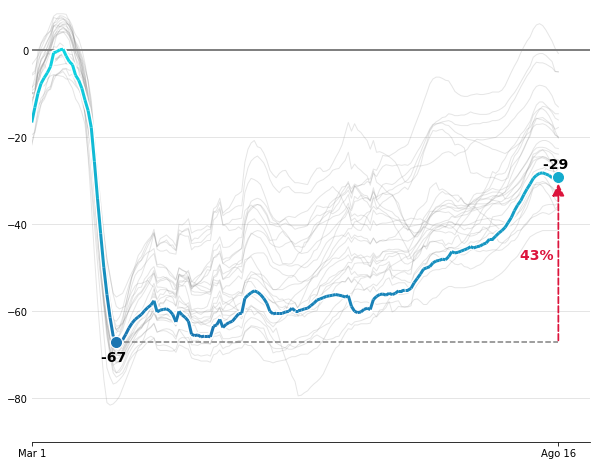

In [93]:
fig, ax = plt.subplots(figsize=(10,8))

# Changes the index to a numeric sequence in a new dataframe
mob = mobility.copy()
mob.index = np.arange(len(mobility.index))

# Plots the data of the states in grey lines
mob.plot(legend=False, color="grey", linewidth=1, alpha=0.2, ax=ax)
mob['Rio Grande do Norte'].plot(legend=False, color='white', linewidth=6, ax=ax)

x = mob.index
y = np.array(mob['Rio Grande do Norte'])

# Creates the segments for the highlighted line
segs = create_segments(x, y)

# Defines min and max values to convert y-values in colors
norm = plt.Normalize(y.min(), y.max())

# Creates the colormap with a gradient between two blue shades
cdict = {
    'red': [[0.0, 0.0, 0.10196078431372549], [1.0, 0.054901960784313725, 0.0]],
    'green': [[0.0, 0.0, 0.4588235294117647], [1.0, 0.8352941176470589, 0.0]],
    'blue': [[0.0, 0.0, 0.6941176470588235], [1.0, 0.8862745098039215, 0.0]]
    }
blue_gradient = mcolors.LinearSegmentedColormap('Blue Fade', cdict)

# Creates the highlighted line
lc = LineCollection(segs, cmap=blue_gradient, norm=norm, zorder=30, linewidth=3)
lc.set_array(y)
ax.add_collection(lc)

# Sets axes limits
ax.set_xlim(x.min(), x.max() + 10)
ax.set_ylim(-90, 10)

# Sets the labels of X axis
ax.set_xticks([x.min(), x.max()])
ax.set_xticklabels(['Mar 1', 'Ago 16'])

# Gets the lowest and the last point of the line
low = get_lowest(mob['Rio Grande do Norte'])
end = (int(x[-1]), float(y[-1]))

# Adds circles marking each point
plt.scatter([low[0], end[0]], [low[1], end[1]], s=150, zorder=31, color='white')
plt.scatter(low[0], low[1], s=100, zorder=31, color=blue_gradient(norm(low[1])))
plt.scatter(end[0], end[1], s=100, zorder=31, color=blue_gradient(norm(end[1])))

# Adds Adiciona linha cinza no nível do ponto mais baixo
plt.plot([low[0], end[0]], [low[1], low[1]], '--', color='grey')

# Adiciona seta vermelha apontando a variação
ax.annotate("",
            (end[0], int(end[1]) - 1.2),
            (end[0], low[1]),
            zorder=40,
            arrowprops=dict(
                arrowstyle="-|>, head_width=0.5, head_length=1",
                linestyle='--', color='crimson', linewidth=1.75),
            )

# Valores dos pontos mínimo e atual, e a varição
plt.text(low[0], low[1] - 2, f"{int(low[1])} ", verticalalignment='top', horizontalalignment='center', fontsize=14, fontweight='bold', color='black', zorder=32)
plt.text(end[0], end[1] + 2, f"{int(end[1])} ", horizontalalignment='center', fontsize=14, fontweight='bold', color='black', zorder=32)
plt.text(end[0], (end[1] - low[1]) / 2 + low[1], f"{int(end[1] / low[1] * 100)}% ", horizontalalignment='right', fontsize=14, fontweight='bold', color='crimson', zorder=32)

# Adiciona linhas horizontais no gráfico
plt.grid(color='grey', linestyle='-', linewidth=1, axis='y', alpha=0.2)

# Destaca a primeira linha e remove os traços do eixo Y    
ax.get_ygridlines()[-2].set_linewidth(2)
ax.get_ygridlines()[-2].set_alpha(1)
ax.tick_params(axis='y', which='both', length=0)

# Remove o contorno do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

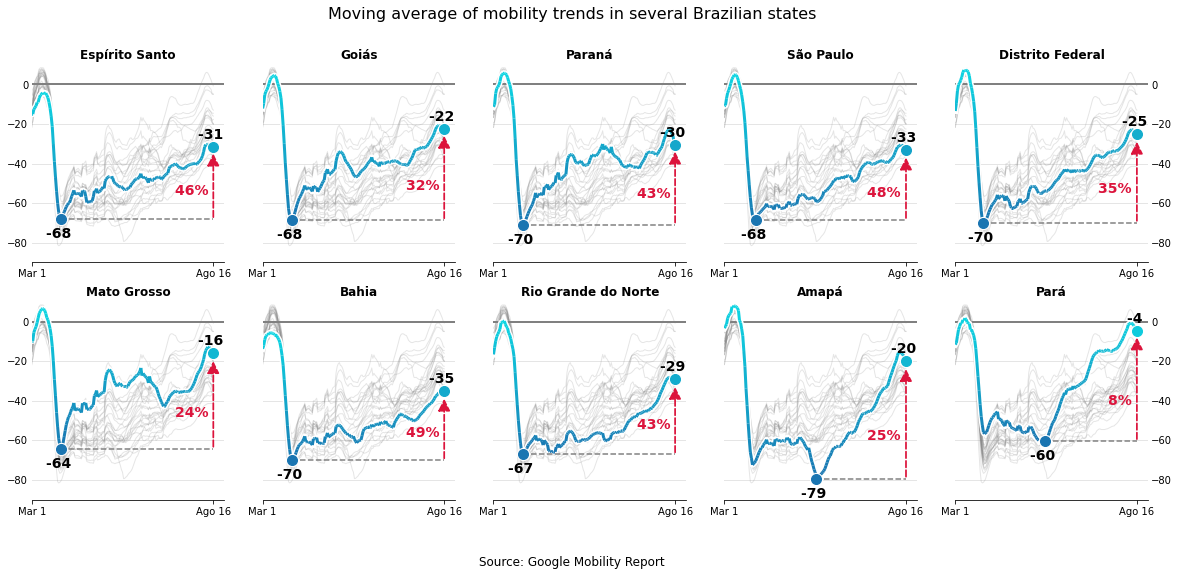

In [95]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,8))

# Altera o index para uma sequência numérica em um novo dataframe
mob = mobility.copy()
mob.index = np.arange(len(mobility.index))

# Cria o colormap com gradiente entre dois tons de azul
cdict = {
    'red': [[0.0, 0.0, 0.10196078431372549], [1.0, 0.054901960784313725, 0.0]],
    'green': [[0.0, 0.0, 0.4588235294117647], [1.0, 0.8352941176470589, 0.0]],
    'blue': [[0.0, 0.0, 0.6941176470588235], [1.0, 0.8862745098039215, 0.0]]
    }
blue_fade = mcolors.LinearSegmentedColormap('Blue Fade', cdict)

states = ["Espírito Santo", "Goiás", "Paraná", "São Paulo", "Distrito Federal",
          "Mato Grosso", "Bahia", "Rio Grande do Norte", "Amapá", "Pará"]

for i, state in enumerate(states):
    row = int(i / 5)
    col = i % 5

    # Adiciona dados dos estados como linha cinza e um fundo branco pra linha em destaque
    mob.plot(legend=False, color="grey", linewidth=1, alpha=0.2, ax=ax[row][col])
    mob[state].plot(legend=False, color="white", linewidth=6, ax=ax[row][col])

    # Cria a linha em destaque
    x = mob.index
    y = np.array(mob[state])

    # Separa os dados da linha em destaque em vários segmentos
    segs = create_segments(x, y)

    # Define valores mínimo e máximo para converter Y em cor
    norm = plt.Normalize(y.min(), y.max())

    # Monta a linha em destaque colorindo os segmentos de acordo com o Y
    lc = LineCollection(segs, cmap=blue_fade, norm=norm, zorder=30, linewidth=3)
    lc.set_array(y)
    ax[row][col].add_collection(lc)

    # Define limites do eixos
    ax[row][col].set_xlim(x.min(), x.max() + 10)
    ax[row][col].set_ylim(-90, 10)

    # Define os rótulos do eixo X
    ax[row][col].set_xticks([x.min(), x.max()])
    ax[row][col].set_xticklabels(['Mar 1', 'Ago 16'])

    ax[row][col].set_title(state, fontsize=12, ha='center', fontweight="bold")

    # Define dados do ponto mais baixo e do último ponto
    low = get_lowest(mob[state])
    end = (int(x[-1]), float(y[-1]))

    # Adiciona círculos marcando os pontos
    ax[row][col].scatter([low[0], end[0]], [low[1], end[1]], s=150, zorder=31, color='white')
    ax[row][col].scatter(low[0], low[1], s=100, zorder=31, color=blue_fade(norm(low[1])))
    ax[row][col].scatter(end[0], end[1], s=100, zorder=31, color=blue_fade(norm(end[1])))

    # Adiciona linha cinza no nível do ponto mais baixo
    ax[row][col].plot([low[0], end[0]], [low[1], low[1]], '--', color='grey')

    # Adiciona seta vermelha apontando a variação
    ax[row][col].annotate("",
                (end[0], int(end[1]) - 3),
                (end[0], low[1]),
                zorder=40,
                arrowprops=dict(
                    arrowstyle="-|>, head_width=0.5, head_length=1",
                    linestyle='--', color='crimson', linewidth=1.75),
                )

    # Valores dos pontos mínimo e atual, e a varição
    ax[row][col].text(low[0], low[1] - 4, f"{int(low[1])} ", verticalalignment='top', horizontalalignment='center', fontsize=14, fontweight='bold', color='black', zorder=32)
    ax[row][col].text(end[0], end[1] + 4, f"{int(end[1])} ", horizontalalignment='center', fontsize=14, fontweight='bold', color='black', zorder=32)
    ax[row][col].text(end[0], (end[1] - low[1]) / 3 + low[1], f"{int(end[1] / low[1] * 100)}% ", horizontalalignment='right', fontsize=14, fontweight='bold', color='crimson', zorder=32)

    # Adiciona linhas horizontais no gráfico
    ax[row][col].grid(color='grey', linestyle='-', linewidth=1, axis='y', alpha=0.2)

    # Remove o contorno do gráfico
    ax[row][col].spines['top'].set_visible(False)
    ax[row][col].spines['right'].set_visible(False)
    ax[row][col].spines['left'].set_visible(False)

    # Destaca a primeira linha e remove os traços do eixo Y    
    ax[row][col].get_ygridlines()[-2].set_linewidth(2)
    ax[row][col].get_ygridlines()[-2].set_alpha(1)
    ax[row][col].tick_params(axis='y', which='both', length=0)

    # Remove os rótulos do eixo Y dos gráficos do meio
    if col != 0 and col != 4:
        ax[row][col].set_yticklabels([])

    # Coloca os rótulos dos eixo Y para a direita no último gráfico da linha
    if col == 4:
        ax[row][col].yaxis.tick_right()

# Adiciona título e fonte na figura
fig.suptitle('Moving average of mobility trends in several Brazilian states', fontsize=16)
plt.figtext(0.5, 0.01, 'Source: Google Mobility Report', wrap=True, horizontalalignment='center', fontsize=12)

plt.show()